In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
sys.path.pop(1)
sys.path.insert(0,'../')
from matplotlib.colors import LogNorm

In [2]:
import pyathena as pa

In [36]:
basedir='/Users/ckim/Research/TIGRESS/'
simid='n2e-4_v1414'

In [37]:
tidx=300
fname='%s%s/id0/%s.%04d.vtk' % (basedir,simid,simid,tidx)
ds=pa.AthenaDataSet(fname)

In [41]:
starfname=fname.replace('id0','starpar').replace('vtk','starpar.vtk')

In [43]:
star=pa.read_starvtk(starfname)

In [44]:
den=ds.read_all_data('density')

In [45]:
Nz,Ny,Nx=den.shape

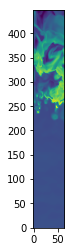

In [53]:
plt.imshow(den[:,Ny/2,:],norm=LogNorm(),origin='lower')

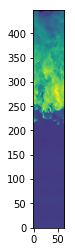

In [51]:
plt.imshow(den.mean(axis=2),norm=LogNorm(),origin='lower')

In [20]:
press=ds.read_all_data('pressure')

In [22]:
cool=pa.coolftn()

In [24]:
temp=cool.get_temp(press/den)

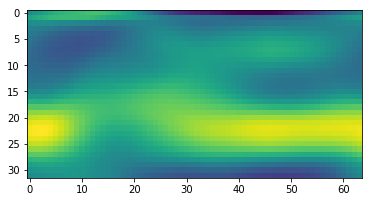

In [26]:
plt.imshow(temp.mean(axis=2),norm=LogNorm(),interpolation='nearest')

In [27]:
pok=den*temp

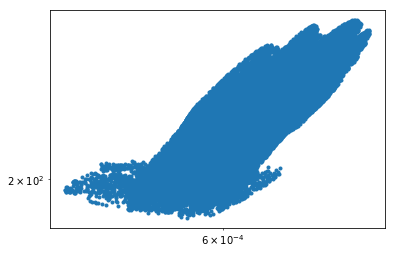

In [28]:
plt.loglog(den.flatten(),pok.flatten(),'.')

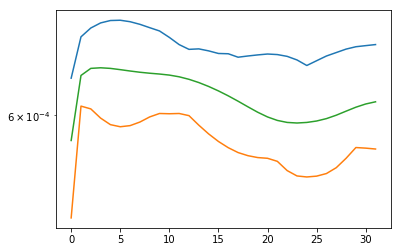

In [29]:
plt.semilogy(den.max(axis=1).max(axis=1))
plt.semilogy(den.min(axis=1).min(axis=1))
plt.semilogy(den.mean(axis=1).mean(axis=1))

In [32]:
hstfname='%s%s/hst/%s.hst' % (basedir,simid,simid)
hst=pa.hst_reader(hstfname)

../pyathena/ath_hst.py:60: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  hst = pd.read_table(filename,skiprows=nheader,names=varlist,sep='\s*',comment='#')


Reading a history file:/Users/ckim/Research/TIGRESS/n2e-4_v1414/hst/n2e-4_v1414.hst


In [73]:
hratio=np.interp(ds.domain['time'],hst.time,hst.heat_ratio)

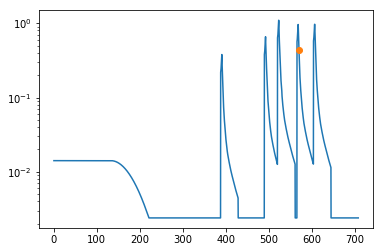

In [80]:
plt.plot(hst.time,hst.heat_ratio)
plt.plot(ds.domain['time'],np.interp(ds.domain['time'],hst.time,hst.heat_ratio),'o')
plt.yscale('log')

/tigress/changgoo/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


(0, 5)

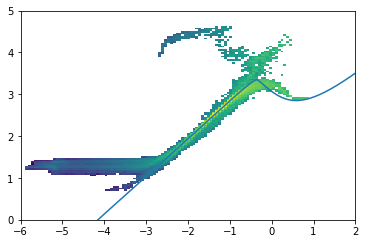

In [79]:
nden=coolftn.heat*hratio/coolftn.cool
pok=nden*coolftn.temp
plt.imshow(h[0].T,origin='lower',norm=LogNorm(),extent=[h[1].min(),h[1].max(),h[2].min(),h[2].max()])
plt.plot(np.log10(nden),np.log10(pok))
plt.xlim(-6,2)
plt.ylim(0,5)